# <a id="0">Содержание</a>

- <a href="#1">Импорт необходимых библиотек</a>
- <a href="#2">Чтение и подготовка данных</a>
- <a href="#3">Подбор параметров на различных метриках качества</a>
    - <a href="#31">MSE</a>
    - <a href="#32">MAE</a>
    - <a href="#33">SMLAR</a>
- <a href="#4">Обучение моделей регрессии</a>  
    - <a href="#41">LightGBM</a>
    - <a href="#42">CatBoost</a>
    - <a href="#43">XGBoost</a>
    - <a href="#44">Сравнение моделей</a>

## <a id="1">Импорт необходимых библиотек</a>

In [50]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import pickle
import time
from math import exp

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

## <a id="2">Чтение и подготовка данных</a>

In [51]:
# Чтение файла
df = pd.read_csv('../feature_engeniting/data_to_train.csv')

# Чтение при обучении из google colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_to_train.csv')

# Предпросмотр данных
df.head()

,count,publisher_1,publisher_10,publisher_11,publisher_12,publisher_13,publisher_14,publisher_15,publisher_16,publisher_17,...,city_17,city_19,city_201,city_21,city_25,city_3,city_60,city_7,city_8,city_other
0,23,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
# Знакомство с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495001 entries, 0 to 495000
Data columns (total 66 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   count                495001 non-null  int64  
 1   publisher_1          495001 non-null  int64  
 2   publisher_10         495001 non-null  int64  
 3   publisher_11         495001 non-null  int64  
 4   publisher_12         495001 non-null  int64  
 5   publisher_13         495001 non-null  int64  
 6   publisher_14         495001 non-null  int64  
 7   publisher_15         495001 non-null  int64  
 8   publisher_16         495001 non-null  int64  
 9   publisher_17         495001 non-null  int64  
 10  publisher_18         495001 non-null  int64  
 11  publisher_19         495001 non-null  int64  
 12  publisher_2          495001 non-null  int64  
 13  publisher_20         495001 non-null  int64  
 14  publisher_21         495001 non-null  int64  
 15  publisher_3      

In [53]:
# Посмотрим на столбец city_group, имеющий тип object
df['city_group'].value_counts()

city_group
other    249317
0        141684
3         35444
7         22418
25         5709
19         5472
60         5462
8          4855
201        4570
21         4377
17         3939
Name: count, dtype: int64

In [54]:
# Посмотрим на отличие столбцов sex и sex_binary
print(df['sex'].value_counts())
print(df['sex_binary'].value_counts())

sex
1.0    255653
2.0    227438
0.0       156
Name: count, dtype: int64
sex_binary
1.0    255653
0.0    227594
Name: count, dtype: int64


In [55]:
# Выделим таргет и удалим столбецы city_group и sex, сотавшиймя после предобработки
X = df.drop(['count', 'city_group', 'sex'], axis=1)
y = df['count']

# Разобьем выборки на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Стандартизируем данные
sc = StandardScaler()
sc.fit(X_train)
X_train_sc=sc.transform(X_train)
X_test_sc=sc.transform(X_test)

Text(0.5, 1.0, 'Распределение таргетов')

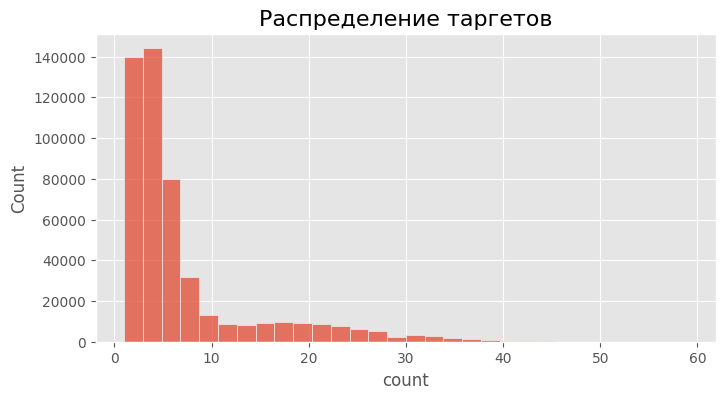

In [57]:
fig = plt.figure(figsize=(8, 4))
histplot = sns.histplot(
    data=df,
    x='count',
    bins=30,
    #kde=True,
)
histplot.set_title('Распределение таргетов', fontsize=16)

## <a id="3">Тестовое обучение на различных метриках качества</a>

### <a id="31">MSE</a>

In [58]:
# Функция расчета метрики Smoothed Mean Log Accuracy Ratio
def smlar(y, y_pred, e=0.005):
    return exp(np.sum(abs(np.log((abs(y_pred) + e)/(y + e))))/len(y)) - 1

In [59]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-17 16:08:03,158] A new study created in memory with name: no-name-b15b6d99-8b8f-47e4-8175-353efa11fe11


[I 2024-12-17 16:08:10,051] Trial 0 finished with value: 7.502362223727941 and parameters: {'lambda_l2': 0.7507491080872166, 'max_depth': 65, 'num_leaves': 65, 'learning_rate': 0.041, 'bagging_fraction': 0.5}. Best is trial 0 with value: 7.502362223727941.
[I 2024-12-17 16:08:13,619] Trial 1 finished with value: 6.5970709975160045 and parameters: {'lambda_l2': 0.49494158018706025, 'max_depth': 40, 'num_leaves': 35, 'learning_rate': 0.651, 'bagging_fraction': 0.5}. Best is trial 1 with value: 6.5970709975160045.
[I 2024-12-17 16:08:17,760] Trial 2 finished with value: 6.422381356054551 and parameters: {'lambda_l2': 0.6291159939571274, 'max_depth': 17, 'num_leaves': 65, 'learning_rate': 0.521, 'bagging_fraction': 0.8}. Best is trial 2 with value: 6.422381356054551.
[I 2024-12-17 16:08:20,982] Trial 3 finished with value: 9.171794008085765 and parameters: {'lambda_l2': 0.9393281789937334, 'max_depth': 99, 'num_leaves': 5, 'learning_rate': 0.171, 'bagging_fraction': 0.7}. Best is trial 2 w

In [60]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший MSE: 6.156863969445089
  Параметры: 
    lambda_l2: 0.994901515446466
    max_depth: 58
    num_leaves: 105
    learning_rate: 0.291
    bagging_fraction: 0.6


In [61]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 42.95%
MAE LightGBM: 1.699
MSE LightGBM: 6.157
R2_score LightGBM: 89.10%


### <a id="32">MAE</a>

In [62]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbosity':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-17 16:10:29,334] A new study created in memory with name: no-name-02ca1c18-65a4-4a0d-b8ec-63d2e3bd8553
[I 2024-12-17 16:10:34,463] Trial 0 finished with value: 1.7311411303581759 and parameters: {'lambda_l2': 0.517523923139172, 'max_depth': 17, 'num_leaves': 85, 'learning_rate': 0.221, 'bagging_fraction': 0.8}. Best is trial 0 with value: 1.7311411303581759.
[I 2024-12-17 16:10:42,112] Trial 1 finished with value: 1.793978820754862 and parameters: {'lambda_l2': 0.2264376947371633, 'max_depth': 49, 'num_leaves': 85, 'learning_rate': 0.07100000000000001, 'bagging_fraction': 0.5}. Best is trial 0 with value: 1.7311411303581759.
[I 2024-12-17 16:10:46,857] Trial 2 finished with value: 1.7053703311807997 and parameters: {'lambda_l2': 0.4534957944524005, 'max_depth': 29, 'num_leaves': 105, 'learning_rate': 0.281, 'bagging_fraction': 0.8}. Best is trial 2 with value: 1.7053703311807997.
[I 2024-12-17 16:10:51,479] Trial 3 finished with value: 1.7057246919356506 and parameters: {'la

In [63]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший MAE: 1.702532140510647
  Параметры: 
    lambda_l2: 0.23467414743315748
    max_depth: 61
    num_leaves: 105
    learning_rate: 0.331
    bagging_fraction: 0.6


In [64]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 43.07%
MAE LightGBM: 1.703
MSE LightGBM: 6.140
R2_score LightGBM: 89.13%


### <a id="33">SMLAR</a>

In [65]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    smlar_lgbm = smlar(y_test, y_pred)
    return smlar_lgbm

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=30)

[I 2024-12-17 16:12:50,726] A new study created in memory with name: no-name-8b86c2b4-03f7-4ae6-862a-17fb2a316436
[I 2024-12-17 16:12:56,517] Trial 0 finished with value: 0.4522951569437925 and parameters: {'lambda_l2': 0.7995262404081859, 'max_depth': 82, 'num_leaves': 65, 'learning_rate': 0.091, 'bagging_fraction': 0.6}. Best is trial 0 with value: 0.4522951569437925.
[I 2024-12-17 16:13:00,362] Trial 1 finished with value: 0.4429078244185154 and parameters: {'lambda_l2': 0.3632846826015085, 'max_depth': 17, 'num_leaves': 35, 'learning_rate': 0.381, 'bagging_fraction': 0.7}. Best is trial 1 with value: 0.4429078244185154.
[I 2024-12-17 16:13:04,488] Trial 2 finished with value: 0.4507066540192177 and parameters: {'lambda_l2': 0.8043176153912899, 'max_depth': 52, 'num_leaves': 75, 'learning_rate': 0.771, 'bagging_fraction': 0.8}. Best is trial 1 with value: 0.4429078244185154.
[I 2024-12-17 16:13:08,270] Trial 3 finished with value: 0.4423823232587447 and parameters: {'lambda_l2': 0.9

In [66]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший SMLAR: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 30
Лучший трайл:
  Лучший SMLAR: 0.43166297619525196
  Параметры: 
    lambda_l2: 0.8890331425986654
    max_depth: 69
    num_leaves: 105
    learning_rate: 0.251
    bagging_fraction: 0.7


In [67]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")

SMLAR LightGBM: 43.17%
MAE LightGBM: 1.709
MSE LightGBM: 6.229
R2_score LightGBM: 88.97%


## <a id="4">Обучение моделей регрессии</a>

### <a id="41">LightGBM</a>

In [68]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbose':-1,
            "objective": "regression",
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae_lgbm = mean_absolute_error(y_test, y_pred)
    return mae_lgbm

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=100)

[I 2024-12-17 16:15:12,924] A new study created in memory with name: no-name-4259b68a-af2f-4742-9d16-b28676565eb9
[I 2024-12-17 16:15:17,861] Trial 0 finished with value: 1.7523889621982354 and parameters: {'lambda_l2': 0.1373152553039106, 'max_depth': 14, 'num_leaves': 45, 'learning_rate': 0.301, 'bagging_fraction': 0.5}. Best is trial 0 with value: 1.7523889621982354.
[I 2024-12-17 16:15:22,303] Trial 1 finished with value: 1.74468028567487 and parameters: {'lambda_l2': 0.3700066696373552, 'max_depth': 55, 'num_leaves': 85, 'learning_rate': 0.731, 'bagging_fraction': 0.7}. Best is trial 1 with value: 1.74468028567487.
[I 2024-12-17 16:15:27,734] Trial 2 finished with value: 1.8371141543765401 and parameters: {'lambda_l2': 0.25184225609676236, 'max_depth': 36, 'num_leaves': 35, 'learning_rate': 0.081, 'bagging_fraction': 0.8}. Best is trial 1 with value: 1.74468028567487.
[I 2024-12-17 16:15:31,381] Trial 3 finished with value: 1.7661863087734824 and parameters: {'lambda_l2': 0.298027

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

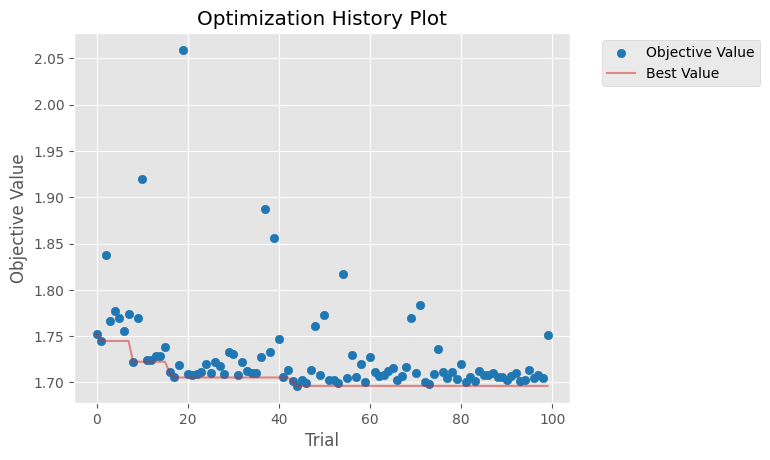

In [69]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_reg)

In [70]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.6961066155092983
  Параметры: 
    lambda_l2: 0.8562333525764684
    max_depth: 88
    num_leaves: 105
    learning_rate: 0.331
    bagging_fraction: 0.5


In [71]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test_sc)

# Конец временного промежутка
lgbm_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_lgbm = smlar(y_test, y_pred_lgbm_reg)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"SMLAR LightGBM: {smlar_lgbm * 100 :.2f}%")
print(f"MAE LightGBM: {mae_lgbm:.3f}")
print(f"MSE LightGBM: {mse_lgbm:.3f}")
print(f"R2_score LightGBM: {r2_lgbm * 100 :.2f}%")
print(f"Время обучения LightGBM: {lgbm_reg_time:.2f} сек")

SMLAR LightGBM: 42.79%
MAE LightGBM: 1.696
MSE LightGBM: 6.132
R2_score LightGBM: 89.15%
Время обучения LightGBM: 4.64 сек


In [72]:
# вычисление SHAP-значений
explainer_lgbm = shap.Explainer(lgbm_reg)
shap_values_lgbm = explainer_lgbm(X_test)

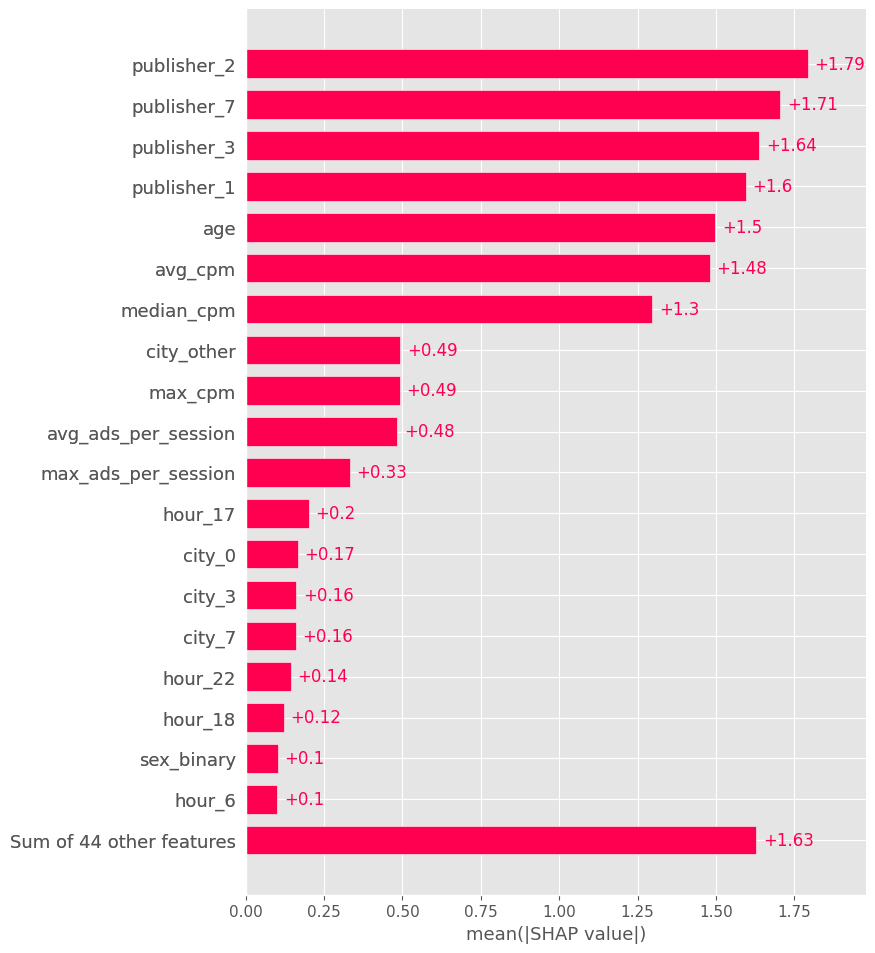

In [73]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_lgbm, max_display=20)

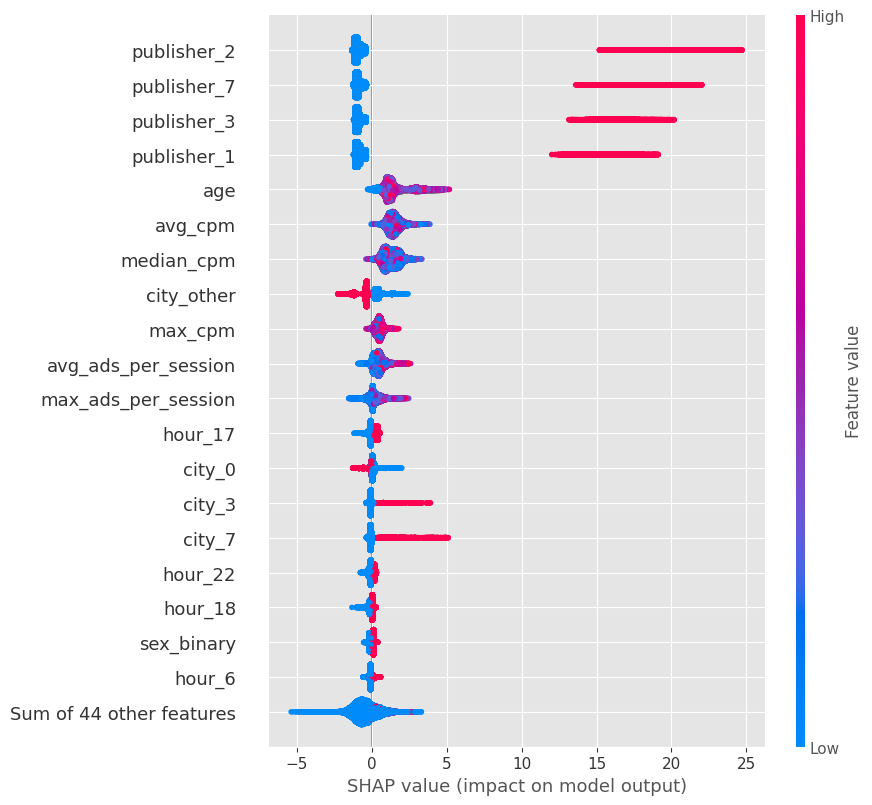

In [74]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_lgbm, max_display=20)

In [75]:
# Сохраним модель
with open(r'models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)
    
# Сохранение для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/lgbm_model.pkl', 'wb') as file:
#     pickle.dump(lgbm_reg, file)

### <a id="42">CatBoost</a>

In [76]:
def objective_catb_reg(trial):
    # Подбираемые параметры
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучаем модель
    optuna_model = CatBoostRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_catb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_catb_reg.optimize(objective_catb_reg, n_trials=100)

[I 2024-12-17 16:26:30,412] A new study created in memory with name: no-name-246ce52b-0f36-4d4d-b6c7-f7600c54f078


[I 2024-12-17 16:26:58,019] Trial 0 finished with value: 2.0158418974457444 and parameters: {'iterations': 289, 'learning_rate': 0.012884690146191253, 'depth': 9, 'l2_leaf_reg': 1.3901468472475076e-08, 'random_strength': 0.036382443767526064, 'bagging_temperature': 2.6565063136859832, 'od_type': 'IncToDec', 'od_wait': 30}. Best is trial 0 with value: 2.0158418974457444.
[I 2024-12-17 16:28:01,269] Trial 1 finished with value: 2.1877459932785426 and parameters: {'iterations': 463, 'learning_rate': 0.004273845303025828, 'depth': 10, 'l2_leaf_reg': 0.04591887952547251, 'random_strength': 0.0011375376113318078, 'bagging_temperature': 3.957492573212018, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 0 with value: 2.0158418974457444.
[I 2024-12-17 16:28:35,288] Trial 2 finished with value: 1.746865744544063 and parameters: {'iterations': 430, 'learning_rate': 0.08267510099378472, 'depth': 9, 'l2_leaf_reg': 0.000667830192135449, 'random_strength': 0.8978150776056056, 'bagging_temperatur

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

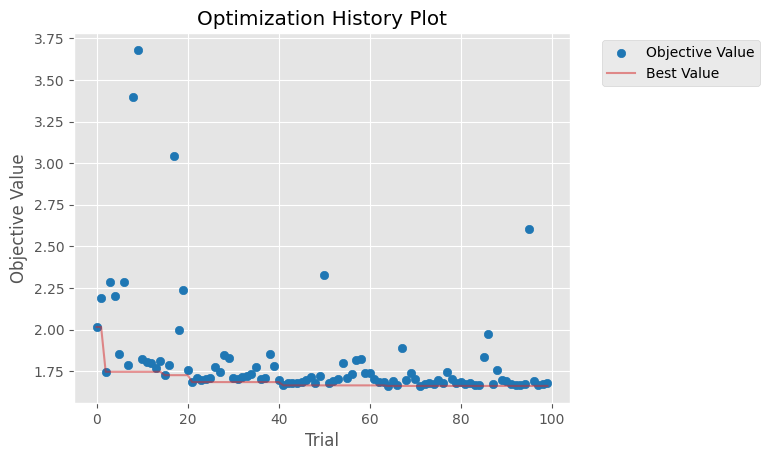

In [77]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_catb_reg)

In [78]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_reg.trials)))
print('Лучший трайл:')
trial = study_catb_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.6619332117216308
  Параметры: 
    iterations: 966
    learning_rate: 0.09922131639585842
    depth: 10
    l2_leaf_reg: 0.02093121999277889
    random_strength: 3.8878846704860285e-06
    bagging_temperature: 7.139403500303873
    od_type: Iter
    od_wait: 49


In [79]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
catb_reg = CatBoostRegressor(verbose=0,**params)
catb_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_catb_reg = catb_reg.predict(X_test_sc)

# Конец временного промежутка
catb_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_catb = smlar(y_test, y_pred_catb_reg)
mae_catb = mean_absolute_error(y_test, y_pred_catb_reg)
mse_catb = mean_squared_error(y_test, y_pred_catb_reg)
r2_catb = r2_score(y_test, y_pred_catb_reg)

# Выводим основные метрики
print(f"SMLAR CatBoost: {smlar_catb * 100 :.2f}%")
print(f"MAE CatBoost: {mae_catb:.3f}")
print(f"MSE CatBoost: {mse_catb:.3f}")
print(f"R2_score CatBoost: {r2_catb * 100 :.2f}%")
print(f"Время обучения CatBoost: {catb_reg_time:.2f} сек")

SMLAR CatBoost: 41.80%
MAE CatBoost: 1.662
MSE CatBoost: 5.908
R2_score CatBoost: 89.54%
Время обучения CatBoost: 118.78 сек


In [80]:
# вычисление SHAP-значений
explainer_catb = shap.Explainer(catb_reg)
shap_values_catb = explainer_catb(X_test)

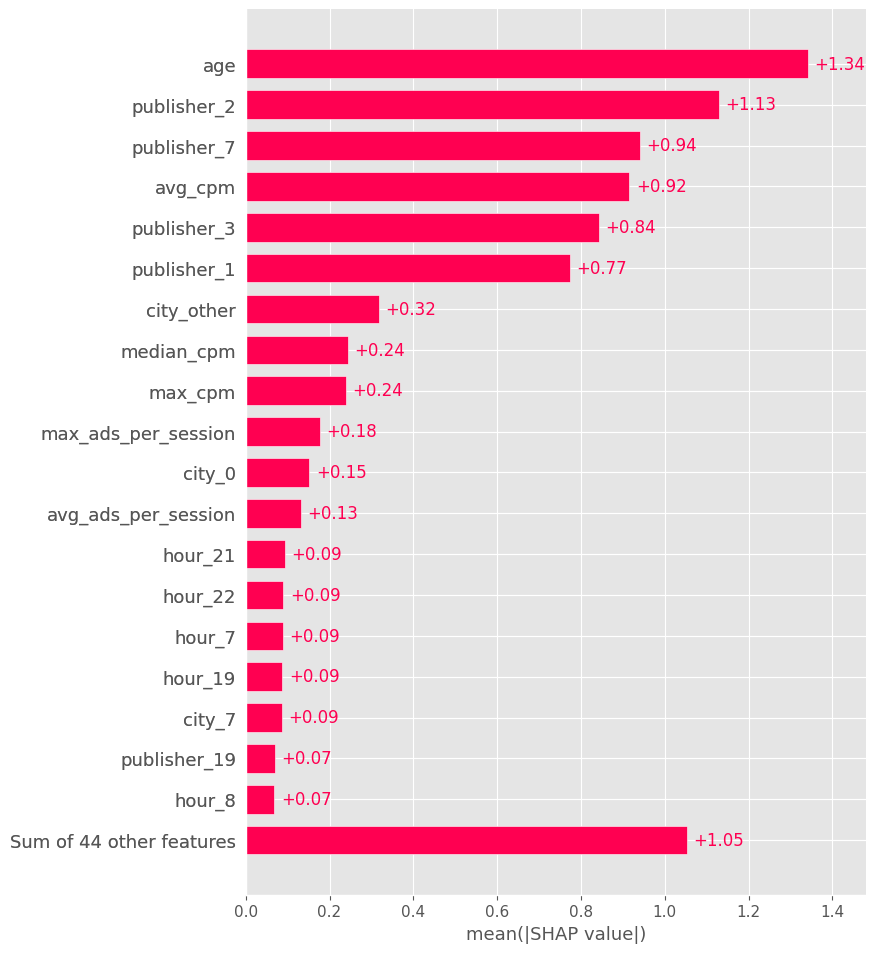

In [81]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_catb, max_display=20)

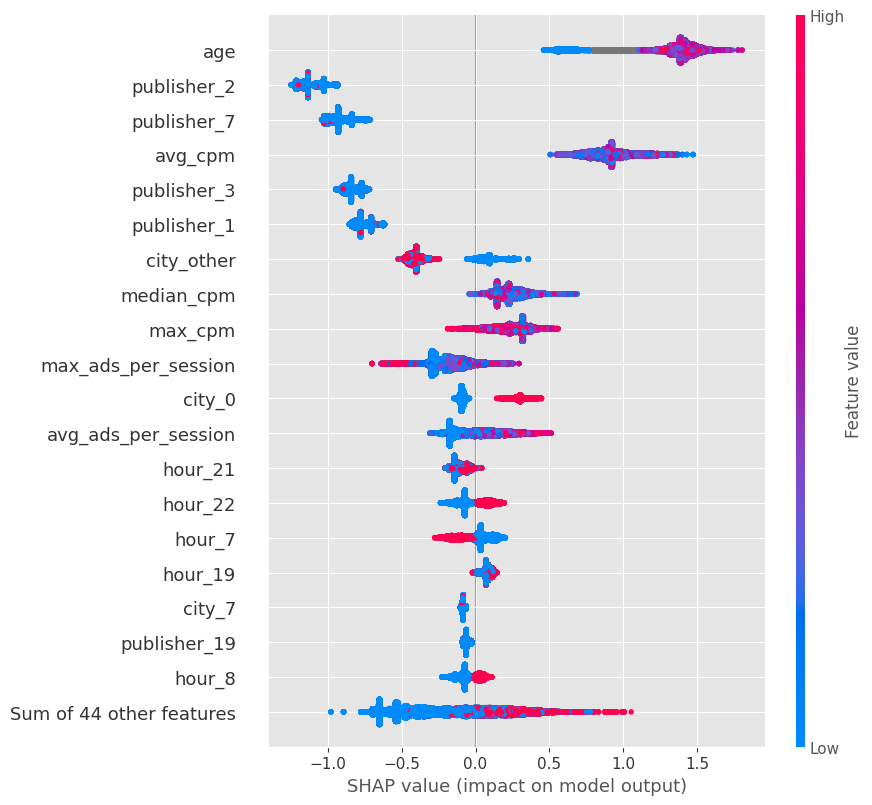

In [82]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_catb, max_display=20)

In [83]:
# Сохраним модель
with open(r'models/catb_model.pkl', 'wb') as file:
    pickle.dump(catb_reg, file)
    
# Сохранение модели для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/catb_model.pkl', 'wb') as file:
#     pickle.dump(catb_reg, file)

### <a id="43">XGBoost</a>

In [84]:
def objective_xgb_reg(trial):
    # Подбираемые параметры
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучаем модель
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train_sc, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test_sc)

    # Оценка предсказания
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Создаем сессию для минимизации выбранной метрики
study_xgb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_xgb_reg.optimize(objective_xgb_reg, n_trials=100)

[I 2024-12-17 19:02:20,229] A new study created in memory with name: no-name-c33460dc-e403-4f3d-b8fa-6f548a5a56dd
[I 2024-12-17 19:03:31,007] Trial 0 finished with value: 1.6609262228012085 and parameters: {'learning_rate': 0.10520879375455051, 'n_estimators': 977, 'max_depth': 8, 'subsample': 0.6114025458800116, 'colsample_bytree': 0.789241077373279}. Best is trial 0 with value: 1.6609262228012085.
[I 2024-12-17 19:04:23,106] Trial 1 finished with value: 1.6862306594848633 and parameters: {'learning_rate': 0.06789596707576676, 'n_estimators': 827, 'max_depth': 7, 'subsample': 0.8106274701971455, 'colsample_bytree': 0.7556255167243189}. Best is trial 0 with value: 1.6609262228012085.
[I 2024-12-17 19:05:04,632] Trial 2 finished with value: 1.8160878419876099 and parameters: {'learning_rate': 0.011315688003328784, 'n_estimators': 480, 'max_depth': 9, 'subsample': 0.6350550720056243, 'colsample_bytree': 0.9773429395534134}. Best is trial 0 with value: 1.6609262228012085.
[I 2024-12-17 19

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

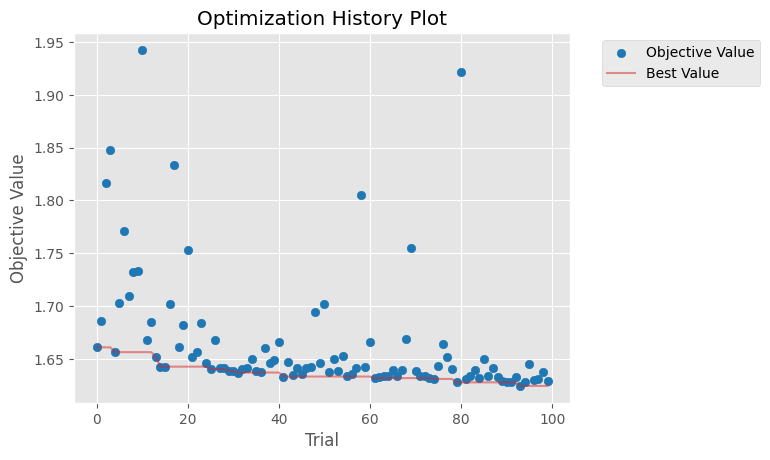

In [85]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_xgb_reg)

In [86]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_reg.trials)))
print('Лучший трайл:')
trial = study_xgb_reg.best_trial

print('  Лучший MAE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MAE: 1.624379277229309
  Параметры: 
    learning_rate: 0.11524637457285798
    n_estimators: 958
    max_depth: 9
    subsample: 0.9769792742210712
    colsample_bytree: 0.8499573611874244


In [87]:
# Засечем время, которое алгоритму потребуется на обучение
start_time = time.time()

# Обучим модель на получившихся параметрах
params = trial.params
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train_sc, y_train)

# Предсказание
y_pred_xgb_reg = xgb_reg.predict(X_test_sc)

# Конец временного промежутка
xgb_reg_time = time.time() - start_time

# Считаем основные метрики
smlar_xgb = smlar(y_test, y_pred_xgb_reg)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_reg)
mse_xgb = mean_squared_error(y_test, y_pred_xgb_reg)
r2_xgb = r2_score(y_test, y_pred_xgb_reg)

# Выводим основные метрики
print(f"SMLAR XGBoost: {smlar_xgb * 100 :.2f}%")
print(f"MAE XGBoost: {mae_xgb:.3f}")
print(f"MSE XGBoost: {mse_xgb:.3f}")
print(f"R2_score XGBoost: {r2_xgb * 100 :.2f}%")
print(f"Время обучения LightGBM: {xgb_reg_time:.2f} сек")

SMLAR XGBoost: 41.22%
MAE XGBoost: 1.624
MSE XGBoost: 5.596
R2_score XGBoost: 90.10%
Время обучения LightGBM: 66.94 сек


In [88]:
# вычисление SHAP-значений
explainer_xgb = shap.Explainer(xgb_reg)
shap_values_xgb = explainer_xgb(X_test)

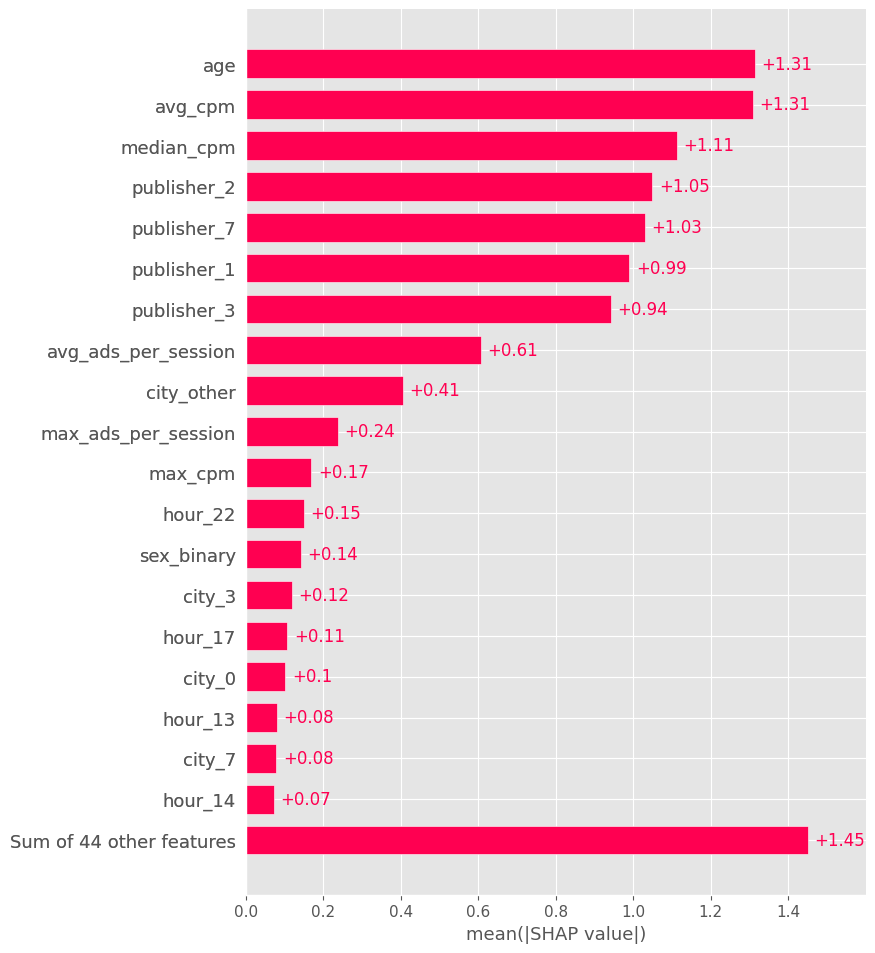

In [89]:
# определение признаков, являющихся наиболее важными для прогнозов
shap.plots.bar(shap_values_xgb, max_display=20)

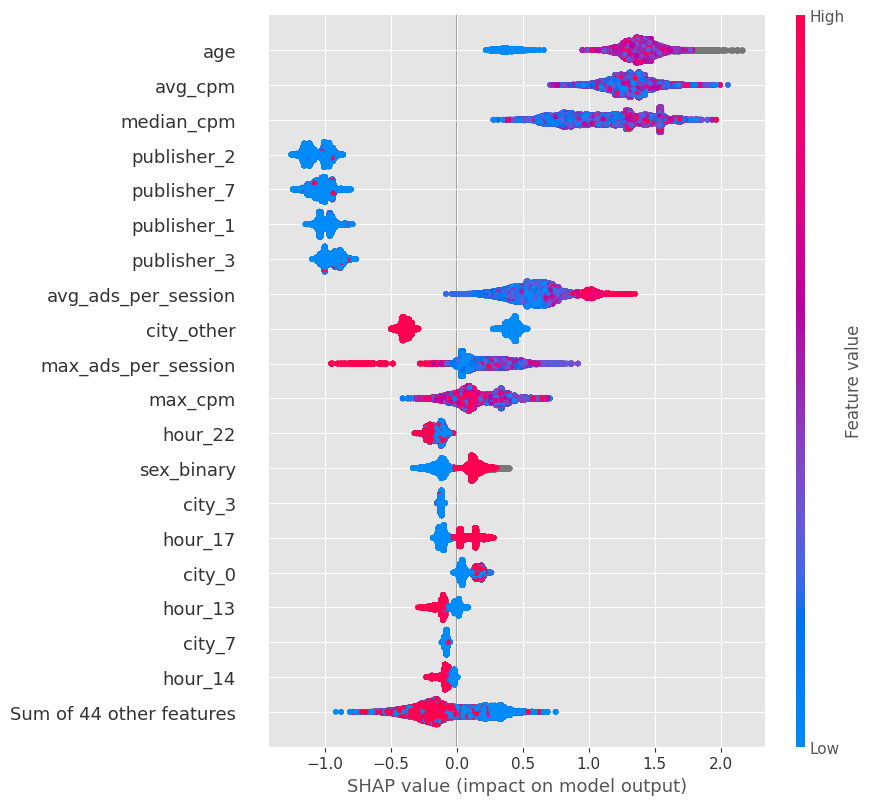

In [90]:
# визуализация всех SHAP‑значений для признаков
shap.plots.beeswarm(shap_values_xgb, max_display=20)

In [91]:
# Сохраним модель
with open(r'models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

# Сохранение для google colab
# with open(r'/content/drive/MyDrive/Colab Notebooks/models/xgb_model.pkl', 'wb') as file:
#     pickle.dump(xgb_reg, file)

### <a id="44">Сравнение моделей</a>

In [92]:
# Соберем основные метрики по моделям в одну таблицу
regression_df = pd.DataFrame(
    data = [
        [f'{mse_lgbm:.4f}', f'{mse_catb:.4f}', f'{mse_xgb:.4f}'],
        [f'{mae_lgbm:.4f}', f'{mae_catb:.4f}', f'{mae_xgb:.4f}'],
        [f'{r2_lgbm*100:.1f}%', f'{r2_catb*100:.1f}%', f'{r2_xgb*100:.1f}%'],
        [f'{smlar_lgbm*100:.1f}%', f'{smlar_catb*100:.1f}%', f'{smlar_xgb*100:.1f}%'],
        [f'{lgbm_reg_time:.2f} сек', f'{catb_reg_time:.2f} сек', f'{xgb_reg_time:.2f} сек']
    ],
    columns= ['LightGBM', 'CatBoost', 'XGBoost'],
    index = ['MSE', 'MAE', 'R2-score', 'SMLAR', 'Time']
)
display(regression_df)

,LightGBM,CatBoost,XGBoost
MSE,6.1325,5.9076,5.5961
MAE,1.6961,1.6619,1.6244
R2-score,89.1%,89.5%,90.1%
SMLAR,42.8%,41.8%,41.2%
Time,4.64 сек,118.78 сек,66.94 сек
